# Лабораторная №1. Задача регрессии.

**Шкуратова Д.В. Б9122-01.03.02мкт**


# Import

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from IPython.display import display

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load Dataset
Датасет взят с [Kaggle](https://www.kaggle.com/competitions/critical-temperature-of-superconductors/overview) (Задача с Samsung Innovation Campus Bootcamp)

**Описание задачи:**
>Явление сверхпроводимость одно из самых удивительных по своей природе, но объяснить его с классической точки зрения невозможно.
Данное явление было открыто голландским физиком Хейке Камерлинг-Оннес в 1911 году.

>Сверхпроводимость — свойство некоторых веществ и материалов, электрическое сопротивление которых при понижении температуры до определенного уровня падает до нуля. Сверхпроводимость возникает скачком при понижении температуры. Температура при которой возникает скачок называется критической температурой.

>Несмотря на то, что сверхпроводимость была открыта больше века назад, многие её свойства плохо изучены, например, связь между сверхпроводимостью и химическими/структурными свойствами материалов.

>Вам предлагается разработать алгоритмы машинного обучения, которые позволяют установить связь между химическим составом, различными свойствами сверхпроводниками и их критической температурой.


In [ ]:
df = pd.read_csv('data/train.csv')
formula = pd.read_csv('data/formula_train.csv')
formula.drop(columns=['critical_temp'], inplace=True)
df = pd.concat([df, formula], axis=1)
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,material
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.2La1.8Cu1O4
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.1La1.9Ag0.1Cu0.9O4
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.1La1.9Cu1O4
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.15La1.85Cu1O4
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.3La1.7Cu1O4


In [ ]:
formula.shape[1], df.shape[1] - formula.shape[1]

(87, 82)

# DA
Тренировочный датасет состоит из двух csv файлов:
- formula_train.csv
    - содержит химическую формулу сверхпроводника: колонки являются названиями хим. эл-в, строки содержат кол-во атомов соответствюшего эл-та
- train.csv 
    - содержит другие химические и физические свойства сверхпроводника

<Axes: xlabel='critical_temp', ylabel='Count'>

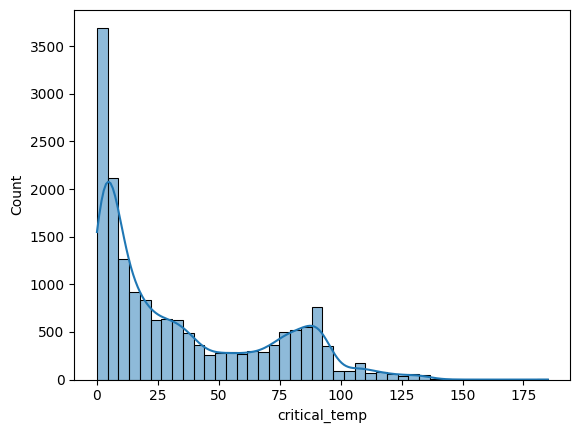

In [ ]:
sns.histplot(df['critical_temp'], kde=True)

In [ ]:
df['critical_temp'].describe()

count    17010.000000
mean        34.502993
std         34.334793
min          0.000210
25%          5.330000
50%         20.000000
75%         63.000000
max        185.000000
Name: critical_temp, dtype: float64

In [ ]:
def get_metric(y_true, y_pred, filter=False):
    if filter:
        y_pred = [0 if i < 0 else i for i in y_pred]
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** (1/2)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return pd.DataFrame({
        'MSE':[mse],
        'RMSE':[rmse],
        'MAE':[mae],
        'R2':[r2]
    })


# Models

## Data preprocessing

In [ ]:
train, test = train_test_split(df, train_size=0.7, random_state=714134)
X_col = df.columns.drop(['critical_temp', 'material'])
y_col = 'critical_temp'

## Linear Model

In [ ]:
lm = LinearRegression()
lasso = Lasso()
ridge = Ridge()

lm = LinearRegression()
lm.fit(train[X_col], train[y_col])
lasso.fit(train[X_col], train[y_col])
ridge.fit(train[X_col], train[y_col])
reg_coef = pd.DataFrame({
    'feature_name':['Intercept'] +  lasso.feature_names_in_.tolist(),
    'lm_coef':  [lm.intercept_] + lm.coef_.tolist(),
    'lasso_wi': [lasso.intercept_] + lasso.coef_.tolist(),
    'ridge_wi': [ridge.intercept_] + ridge.coef_.tolist(),
})
reg_coef

d:\xyz\Projects\MathVenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.739e+05, tolerance: 1.409e+03
  model = cd_fast.enet_coordinate_descent(


,feature_name,lm_coef,lasso_wi,ridge_wi
0,Intercept,-8.943333,-14.245104,-9.498922
1,number_of_elements,0.692345,0.000000,0.381538
2,mean_atomic_mass,1.032552,0.181971,1.025059
3,wtd_mean_atomic_mass,-1.407359,-0.073549,-1.398803
4,gmean_atomic_mass,-0.590392,-0.000000,-0.593808
...,...,...,...,...
163,Pb,1.550200,-0.000000,1.477462
164,Bi,6.483567,0.000000,6.371743
165,Po,0.000000,0.000000,0.000000
166,At,0.000000,0.000000,0.000000


In [ ]:
reg_coef.sort_values('lasso_wi', ascending=False)

,feature_name,lm_coef,lasso_wi,ridge_wi
137,Ba,8.379805,5.381110,8.397381
50,std_ElectronAffinity,1.092518,0.980667,1.102246
43,wtd_mean_ElectronAffinity,0.316509,0.579377,0.336146
63,wtd_mean_ThermalConductivity,0.503313,0.472738,0.486380
23,wtd_mean_atomic_radius,2.372942,0.341740,2.389588
...,...,...,...,...
78,range_Valence,3.954913,-0.423158,3.755210
51,wtd_std_ElectronAffinity,-0.463624,-0.462561,-0.467900
45,wtd_gmean_ElectronAffinity,-0.393668,-0.644364,-0.405427
95,Si,-1.673279,-0.850302,-1.661714


In [ ]:
lm_metric = pd.concat([
    get_metric(train[y_col], lm.predict(train[X_col])),
    get_metric(test[y_col], lm.predict(test[X_col])),
    get_metric(train[y_col], lm.predict(train[X_col]), filter=True),
    get_metric(test[y_col], lm.predict(test[X_col]), filter=True),
    get_metric(train[y_col], lasso.predict(train[X_col])),
    get_metric(test[y_col], lasso.predict(test[X_col])),
    get_metric(train[y_col], lasso.predict(train[X_col]), filter=True),
    get_metric(test[y_col], lasso.predict(test[X_col]), filter=True),
    get_metric(train[y_col], ridge.predict(train[X_col])),
    get_metric(test[y_col], ridge.predict(test[X_col])),
    get_metric(train[y_col], ridge.predict(train[X_col]), filter=True),
    get_metric(test[y_col], ridge.predict(test[X_col]), filter=True),
]).round(4)
lm_metric.index = [
    'lm_train', 'lm_test',
    'f_lm_train', 'f_lm_test',
    'lasso_train', 'lasso_test',
    'f_lasso_train', 'f_lasso_test',
    'ridge_train', 'ridge_test',
    'f_ridge_train', 'f_ridge_test'
]
lm_metric

,MSE,RMSE,MAE,R2
lm_train,261.1368,16.1597,12.0988,0.7794
lm_test,1495.4470,38.6710,13.3255,-0.2809
f_lm_train,252.4888,15.8899,11.6048,0.7867
f_lm_test,284.6953,16.8729,12.1214,0.7561
lasso_train,308.5708,17.5662,13.4031,0.7393
lasso_test,337.7785,18.3788,13.8326,0.7107
f_lasso_train,300.9585,17.3482,12.9167,0.7457
f_lasso_test,329.0310,18.1392,13.3010,0.7182
ridge_train,261.4330,16.1689,12.1024,0.7791
ridge_test,1488.8303,38.5854,13.3173,-0.2752


In [ ]:
def get_pred_plot(y_true, y_pred, filter=False):
    if filter:
        y_pred = [0 if i < 0 else i for i in y_pred]
    fig, ax = plt.subplots(1, 2)
    sns.histplot(y_true, label='true', ax=ax[0])
    sns.histplot(y_pred, label='pred', ax=ax[0])
    ax[0].legend()
    sns.scatterplot(y=y_pred, x=y_true, ax=ax[1])
    sns.lineplot(y=y_true, x=y_true, ax=ax[1])
    plt.show()

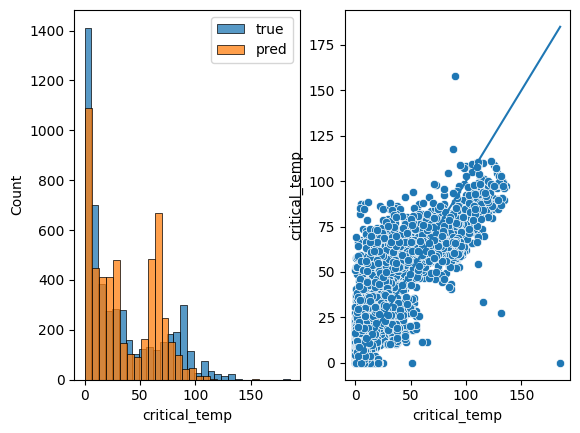

In [ ]:
get_pred_plot(test[y_col], lasso.predict(test[X_col]), filter=True)

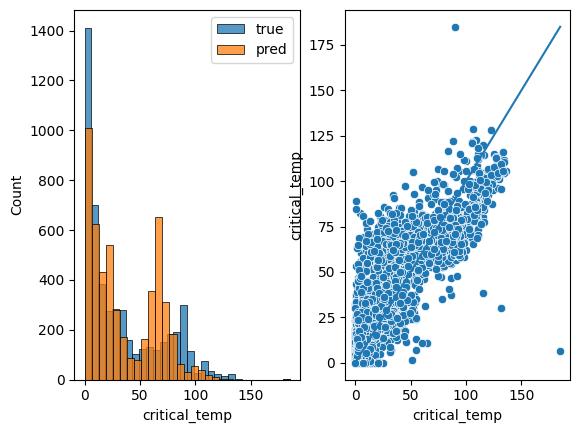

In [ ]:
get_pred_plot(test[y_col], lm.predict(test[X_col]), filter=True)

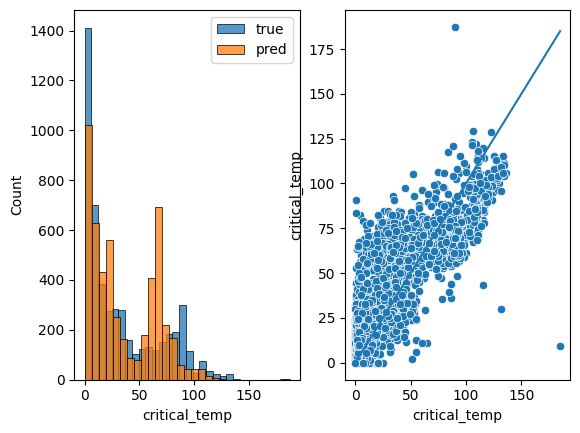

In [ ]:
get_pred_plot(test[y_col], ridge.predict(test[X_col]), filter=True)

## Decision tree

In [ ]:
valid, test = train_test_split(test, train_size=0.5, random_state=54152)

In [ ]:
dt = DecisionTreeRegressor(max_depth=16, criterion='squared_error', min_samples_split=10)
dt.fit(train[X_col], train[y_col])

dt_metric = pd.concat([
    get_metric(train[y_col], dt.predict(train[X_col])),
    get_metric(valid[y_col], dt.predict(valid[X_col])),
    get_metric(test[y_col], dt.predict(test[X_col])),
])
dt_metric.index = ['dt_train', 'dt_valid', 'dt_test']
dt_metric

,MSE,RMSE,MAE,R2
dt_train,45.316573,6.731759,3.826304,0.961710
dt_valid,160.558608,12.671172,6.955515,0.861048
dt_test,139.020118,11.790679,6.490464,0.882131


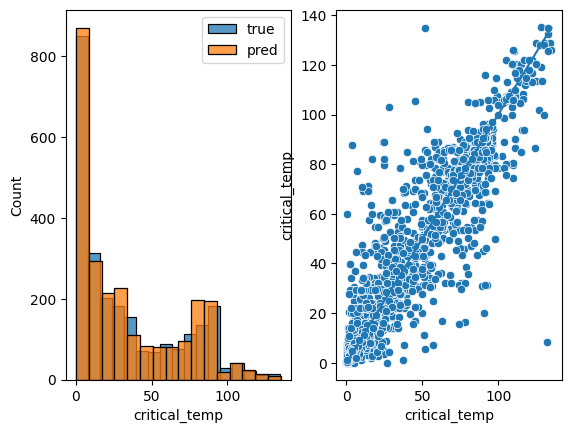

In [ ]:
get_pred_plot(test[y_col], dt.predict(test[X_col]))

In [ ]:
dt_fi = pd.DataFrame({
    'feature_name':dt.feature_names_in_,
    'importance':dt.feature_importances_
})
dt_fi.sort_values('importance', ascending=False)

,feature_name,importance
109,Cu,0.644554
73,gmean_Valence,0.062502
100,Ca,0.049307
136,Ba,0.030324
35,entropy_Density,0.011048
...,...,...
155,Re,0.000000
159,Au,0.000000
164,Po,0.000000
165,At,0.000000


In [ ]:
dt_fi.merge(reg_coef, on='feature_name')[['feature_name', 'lasso_wi', 'importance']].sort_values('importance', ascending=False)

,feature_name,lasso_wi,importance
109,Cu,-0.00000,0.644554
73,gmean_Valence,0.00000,0.062502
100,Ca,0.00000,0.049307
136,Ba,5.38111,0.030324
35,entropy_Density,-0.00000,0.011048
...,...,...,...
155,Re,-0.00000,0.000000
159,Au,-0.00000,0.000000
164,Po,0.00000,0.000000
165,At,0.00000,0.000000


## CatBoost

In [ ]:
formula.columns

Index(['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al',
       'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn',
       'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb',
       'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In',
       'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm',
       'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta',
       'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At',
       'Rn', 'material'],
      dtype='object')

In [ ]:
boost = CatBoostRegressor(
    learning_rate=1e-3,
    max_depth=10,
    rsm=0.5,
    n_estimators=2000,
    verbose=100,
    )
boost.fit(train[X_col], train[y_col])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 34.3760575	total: 62ms	remaining: 2m 3s
100:	learn: 31.9126940	total: 6.36s	remaining: 1m 59s
200:	learn: 29.6982336	total: 13.3s	remaining: 1m 58s
300:	learn: 27.7081825	total: 20.8s	remaining: 1m 57s
400:	learn: 25.9213852	total: 28.8s	remaining: 1m 54s
500:	learn: 24.3189647	total: 36.8s	remaining: 1m 50s
600:	learn: 22.8834863	total: 44.7s	remaining: 1m 44s
700:	learn: 21.6011583	total: 52.9s	remaining: 1m 37s
800:	learn: 20.4580119	total: 1m	remaining: 1m 31s
900:	learn: 19.4446676	total: 1m 9s	remaining: 1m 24s
1000:	learn: 18.5328687	total: 1m 17s	remaining: 1m 17s
1100:	learn: 17.7152136	total: 1m 25s	remaining: 1m 9s
1200:	learn: 16.9894006	total: 1m 33s	remaining: 1m 2s
1300:	learn: 16.3384500	total: 1m 41s	remaining: 54.5s
1400:	learn: 15.7616084	total: 1m 49s	remaining: 46.7s
1500:	learn: 15.2495345	total: 1m 57s	remaining: 38.9s
1600:	learn: 14.7915556	total: 2m 5s	remaining: 31.2s
1700:	learn: 14.3768002	total: 2m 13s	remaining: 23.4s
1800:	learn: 14.0063804	tot

In [ ]:
cat_boost_metric = pd.concat([
    get_metric(train[y_col], boost.predict(train[X_col])),
    get_metric(valid[y_col], boost.predict(valid[X_col])),
    get_metric(test[y_col], boost.predict(test[X_col])),
])
cat_boost_metric.index = ['boost_train', 'boost_valid', 'boost_test']
cat_boost_metric

,MSE,RMSE,MAE,R2
boost_train,235.454606,15.344530,11.845180,0.801053
boost_valid,260.829643,16.150221,12.041365,0.774270
boost_test,253.719074,15.928562,12.149096,0.784883


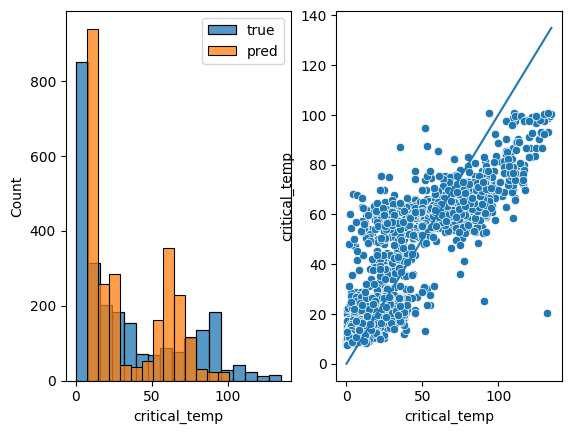

In [ ]:
get_pred_plot(test_cat[y_col], boost.predict(test_cat[X_col]))

In [ ]:
boost_fi = pd.DataFrame({
    'feature_name':boost.feature_names_,
    'importance':boost.feature_importances_
})
boost_fi.sort_values('importance', ascending=False)

,feature_name,importance
67,range_ThermalConductivity,15.530885
27,range_atomic_radius,11.219010
70,wtd_std_ThermalConductivity,6.451523
72,wtd_mean_Valence,6.233940
74,wtd_gmean_Valence,5.059872
...,...,...
162,Pb,0.000000
163,Bi,0.000000
164,Po,0.000000
165,At,0.000000
